FUNDAMENTALS OF QUANTUM ALGORITHMS:

QUANTUM QUERY ALGORITHMS

In [2]:
# qc with query gate for one of four functions
from qiskit import QuantumCircuit

def deutsch_function(case: int):
    """
    Generate a valid Deutsch function as a `QuantumCircuit`.
    """
    if case not in [1, 2, 3, 4]:
        raise ValueError("`case` must be 1, 2, 3, or 4.")

    f = QuantumCircuit(2)
    if case in [2, 3]:
        f.cx(0, 1)
    if case in [3, 4]:
        f.x(1)
    return f

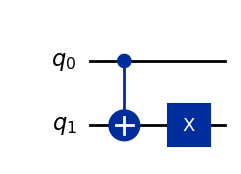

In [3]:
display(deutsch_function(3).draw('mpl'))

In [4]:
# actualy qc for deutsch's algorithm
# subbing query gate with a qc
def compile_circuit(function: QuantumCircuit):
    n = function.num_qubits -1
    qc = QuantumCircuit(n+1,n)

    qc.x(n)
    qc.h(range(n+1))

    qc.barrier()
    qc.compose(function, inplace=True)
    qc.barrier()

    qc.h(range(n))
    qc.measure(range(n), range(n))

    return qc

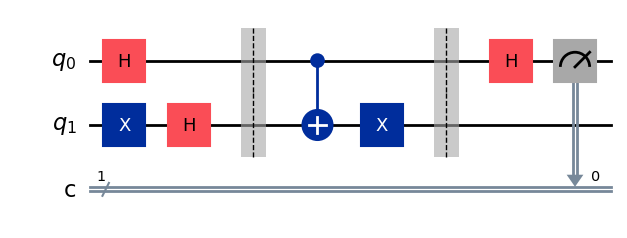

In [5]:
display(compile_circuit(deutsch_function(3)).draw('mpl'))

In [6]:
from qiskit_aer import AerSimulator

def deutsch_algorithm(function: QuantumCircuit):
    '''determine if the deutsch function is constant of balanced'''
    qc = compile_circuit(function)

    result = AerSimulator().run(qc, shots=1, memory=True).result()
    measurments = result.get_memory()
    if measurments[0] == '0':
        return 'constant'
    return 'balanced'


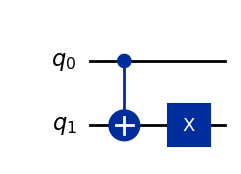

'balanced'

In [7]:
# runs for any of the four functions above
f = deutsch_function(3)
display(f.draw('mpl'))
display(deutsch_algorithm(f))

In [8]:
# deutsch-jozsa algorithm
# 50/50 constant vs. balanced
from qiskit import QuantumCircuit
import numpy as np

def dj_function(num_qubits):
    """
    creates random Deutsch-Jozsa function.
    """

    qc = QuantumCircuit(num_qubits + 1)
    if np.random.randint(0, 2):
        # flip output qubit with 50% chance
        qc.x(num_qubits)
    if np.random.randint(0, 2):
        # return constant circuit with 50% chance
        return qc

    # choose half the possible input states
    on_states = np.random.choice(
        range(2**num_qubits),  # numbers to sample from
        2**num_qubits // 2,  # number of samples
        replace=False,  # makes sure states are only sampled once
    )

    def add_cx(qc, bit_string):
        for qubit, bit in enumerate(reversed(bit_string)):
            if bit == "1":
                qc.x(qubit)
        return qc

    for state in on_states:
        qc.barrier()  # barriers are added to help visualize how the functions are created. They can safely be removed.
        qc = add_cx(qc, f"{state:0b}")
        qc.mcx(list(range(num_qubits)), num_qubits)
        qc = add_cx(qc, f"{state:0b}")

    qc.barrier()

    return qc

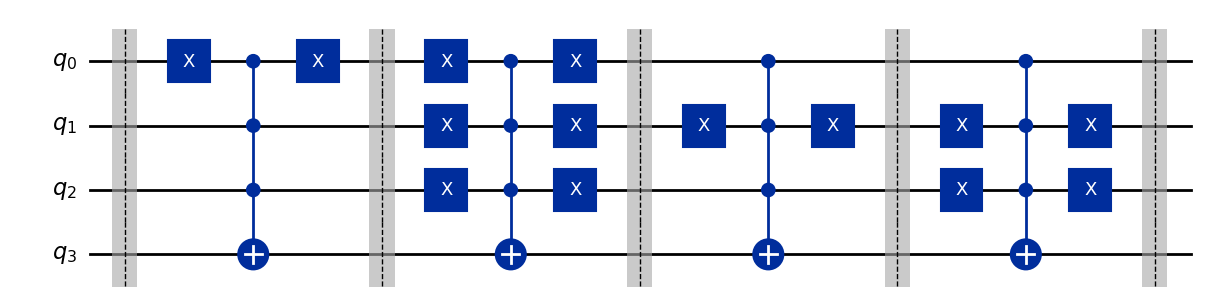

In [9]:
display(dj_function(3).draw('mpl'))

In [10]:
def compile_circuit(function: QuantumCircuit):
    '''compiles circuit for use in dj algorithm'''
    n = function.num_qubits -1
    qc = QuantumCircuit(n+1,n)
    qc.x(n)
    qc.h(range(n+1))
    qc.compose(function, inplace=True)
    qc.h(range(n))
    qc.measure(range(n), range(n))
    return qc

In [11]:
from qiskit_aer import AerSimulator

def dj_algorithm(function: QuantumCircuit):
    """
    determine if a Deutsch-Jozsa function is constant or balanced.
    """
    qc = compile_circuit(function)

    result = AerSimulator().run(qc, shots=1, memory=True).result()
    measurements = result.get_memory()
    if "1" in measurements[0]:
        return "balanced"
    return "constant"

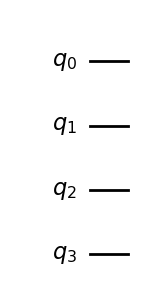

'constant'

In [12]:
f = dj_function(3)
display(f.draw('mpl'))
display(dj_algorithm(f))

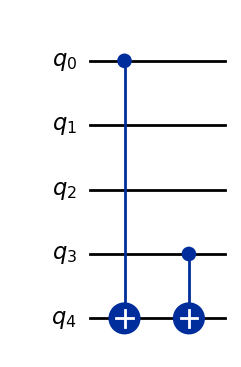

In [13]:
def bv_function(s):
    """
    create a Bernstein-Vazirani function from a string of 1s and 0s.
    """
    qc = QuantumCircuit(len(s) + 1)
    for index, bit in enumerate(reversed(s)):
        if bit == "1":
            qc.cx(index, len(s))
    return qc

display(bv_function("1001").draw('mpl'))

In [14]:
def bv_algorithm(function: QuantumCircuit):
    qc = compile_circuit(function)
    result = AerSimulator().run(qc, shots=1, memory=True).result()
    return result.get_memory()[0]

display(bv_algorithm(bv_function("1001")))

'1001'

In [15]:
# simon's algorithm
# import random
import qiskit.quantum_info as qi
from qiskit import QuantumCircuit
import numpy as np

def simon_function(s: str):
    """
    create a QuantumCircuit implementing a query gate for Simon problem obeying the promise for the hidden string `s`
    """
    # our quantum circuit has 2n qubits for n = len(s)
    n = len(s)
    qc = QuantumCircuit(2 * n)

    # define a random permutation of all n bit strings. This permutation will effectively hide the string s.
    pi = np.random.permutation(2**n)

    # define a query gate explicitly. The idea is to first define a function g(x) = min{x,x ^ s}, which
    # is a simple function that satisfies the promise, and then we take f to be the composition of g and the random
    # permutation pi. This gives us a random function satisfying the promise for s.

    query_gate = np.zeros((4**n, 4**n))
    for x in range(2**n):
        for y in range(2**n):
            z = y ^ pi[min(x, x ^ int(s, 2))]
            query_gate[x + 2**n * z, x + 2**n * y] = 1

    # Our circuit has just this one query gate
    qc.unitary(query_gate, range(2 * n))
    return qc

In [16]:
from qiskit_aer import AerSimulator
from qiskit import ClassicalRegister

def simon_measurements(problem: QuantumCircuit, k: int):
    """
    quantum part of Simon's algorithm. Given a `QuantumCircuit` that
    implements f, get `k` measurements to be post-processed later.
    """
    n = problem.num_qubits // 2

    qc = QuantumCircuit(2 * n, n)
    qc.h(range(n))
    qc.compose(problem, inplace=True)
    qc.h(range(n))
    qc.measure(range(n), range(n))

    result = AerSimulator().run(qc, shots=k, memory=True).result()
    return result.get_memory()

In [17]:
display(simon_measurements(simon_function("11011"),k=12))

['10101',
 '01010',
 '00011',
 '00011',
 '11100',
 '10101',
 '11100',
 '11100',
 '11100',
 '01110',
 '01010',
 '10010']

In [19]:
import numpy as np
import galois

def simon_algorithm(problem: QuantumCircuit):
    """
    Given a `QuantumCircuit` that implements a query gate for Simon problem, return the hidden string `s`.
    """

    # Quantum part: run the circuit defined previously k times and gather the measurement results.
    # Replace +10 by +r for any nonnegative integer r depending on desired confidence.

    measurements = simon_measurements(problem, k=problem.num_qubits // 2 + 10)
    print("Measurement results:")
    display(measurements)

    # Classical post-processing:

    # 1. Convert measurements of form '11101' to 2D-array of integers
    matrix = np.array([list(bitstring) for bitstring in measurements]).astype(int)

    # 2. Interpret matrix as using arithmetic mod 2, and find null space
    null_space = galois.GF(2)(matrix).null_space()
    print("Null space:")
    display(null_space)

    # 3. Convert back to a string
    print("Guess for hidden string s:")
    if len(null_space) == 0:
        # No non-trivial solution; `s` is all-zeros
        return "0" * len(measurements[0])
    return "".join(np.array(null_space[0]).astype(str))

In [20]:
display(simon_algorithm(simon_function("10011")))

Measurement results:


['01100',
 '10101',
 '01011',
 '00011',
 '11101',
 '00100',
 '00111',
 '11101',
 '10010',
 '01100',
 '00100',
 '11010',
 '11110',
 '00000',
 '11001']

Null space:


OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


GF([[1, 0, 0, 1, 1]], order=2)

Guess for hidden string s:


'10011'

QUANTUM ALGORITHMIC FOUNDATIONS:

In [23]:
# integer factorization
from sympy.ntheory import factorint

N = 12
display(factorint(N))

{2: 2, 3: 1}

In [24]:
N = 3402823669209384634633740743176823109843098343
display(factorint(N))

{3: 2, 74519450661011221: 1, 5073729280707932631243580787: 1}

In [25]:
# rsa factoring challenge 
# factorint(RSA1024) would not finish in our lifetime
RSA1024 = 135066410865995223349603216278805969938881475605667027524485143851526510604859533833940287150571909441798207282164471551373680419703964191743046496589274256239341020864383202110372958725762358509643110564073501508187510676594629205563685529475213500852879416377328533906109750544334999811150056977236890927563
display(RSA1024)

135066410865995223349603216278805969938881475605667027524485143851526510604859533833940287150571909441798207282164471551373680419703964191743046496589274256239341020864383202110372958725762358509643110564073501508187510676594629205563685529475213500852879416377328533906109750544334999811150056977236890927563

In [26]:
# number field sieve
RSA250 = 2140324650240744961264423072839333563008614715144755017797754920881418023447140136643345519095804679610992851872470914587687396261921557363047454770520805119056493106687691590019759405693457452230589325976697471681738069364894699871578494975937497937

p = 64135289477071580278790190170577389084825014742943447208116859632024532344630238623598752668347708737661925585694639798853367
q = 33372027594978156556226010605355114227940760344767554666784520987023841729210037080257448673296881877565718986258036932062711

display(RSA250 == p * q)

True

In [27]:
import math

N = 4636759690183918349682239573236686632636353319755818421393667064929987310592347460711767784882455889983961546491666129915628431549982893638464243493812487979530329460863532041588297885958272943021122033997933550246447236884738870576045537199814804920281890355275625050796526864093092006894744790739778376848205654332434378295899591539239698896074
M = 5056714874804877864225164843977749374751021379176083540426461360945653967249306494545888621353613218518084414930846655066495767441010526886803458300440345782982127522212209489410315422285463057656809702949608368597012967321172325810519806487247195259818074918082416290513738155834341957254558278151385588990304622183174568167973121179585331770773

display(math.gcd(N, M))

135066410865995223349603216278805969938881475605667027524485143851526510604859533833940287150571909441798207282164471551373680419703964191743046496589274256239341020864383202110372958725762358509643110564073501508187510676594629205563685529475213500852879416377328533906109750544334999811150056977236890927563

In [28]:
display(math.gcd(N**200 + 1, M**100 + M**2))

113

In [29]:
# measuring computational cost
import galois

GF = galois.GF(2)

N, n = 1000, 1000

A = GF.Random((N, n))
B = A.null_space()
display(B)

GF([[1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1,
     1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1,
     1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
     0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0,
     1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1,
     1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
     1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1,
     1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0,
     0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1,
     1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1,
     0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
     1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0,
     0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0,
     1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 

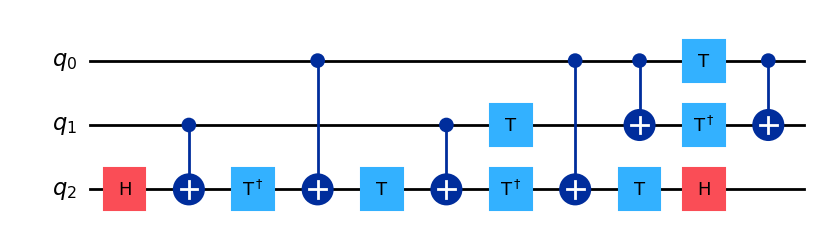

<IPython.core.display.Latex object>

In [31]:
# toffoli gates
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, Operator
from qiskit.visualization import array_to_latex

Toffoli = QuantumCircuit(3)

Toffoli.h(2)
Toffoli.cx(1, 2)
Toffoli.tdg(2)
Toffoli.cx(0, 2)
Toffoli.t(2)
Toffoli.cx(1, 2)
Toffoli.tdg(2)
Toffoli.cx(0, 2)
Toffoli.t(1)
Toffoli.t(2)
Toffoli.cx(0, 1)
Toffoli.t(0)
Toffoli.tdg(1)
Toffoli.h(2)
Toffoli.cx(0, 1)

display(Toffoli.draw('mpl'))
U = Operator(Toffoli)

display(array_to_latex(U))

PHASE-ESTIMATION AND FACTORING:

In [32]:
from qiskit.visualization import array_to_latex
from qiskit.quantum_info import Statevector
from qiskit.quantum_info.operators import Operator
import math

psi1 = Statevector([math.cos(math.pi / 8), math.sin(math.pi / 8)])
psi2 = Statevector([math.cos(5 * math.pi / 8), math.sin(5 * math.pi / 8)])

# When given a Statevector input, the Operator function returns the outer
# product of that state vector with itself — or, in other words, the
# product of the vector times its conjugate transpose.

H = Operator(psi1) - Operator(psi2)

display(array_to_latex(H))

<IPython.core.display.Latex object>

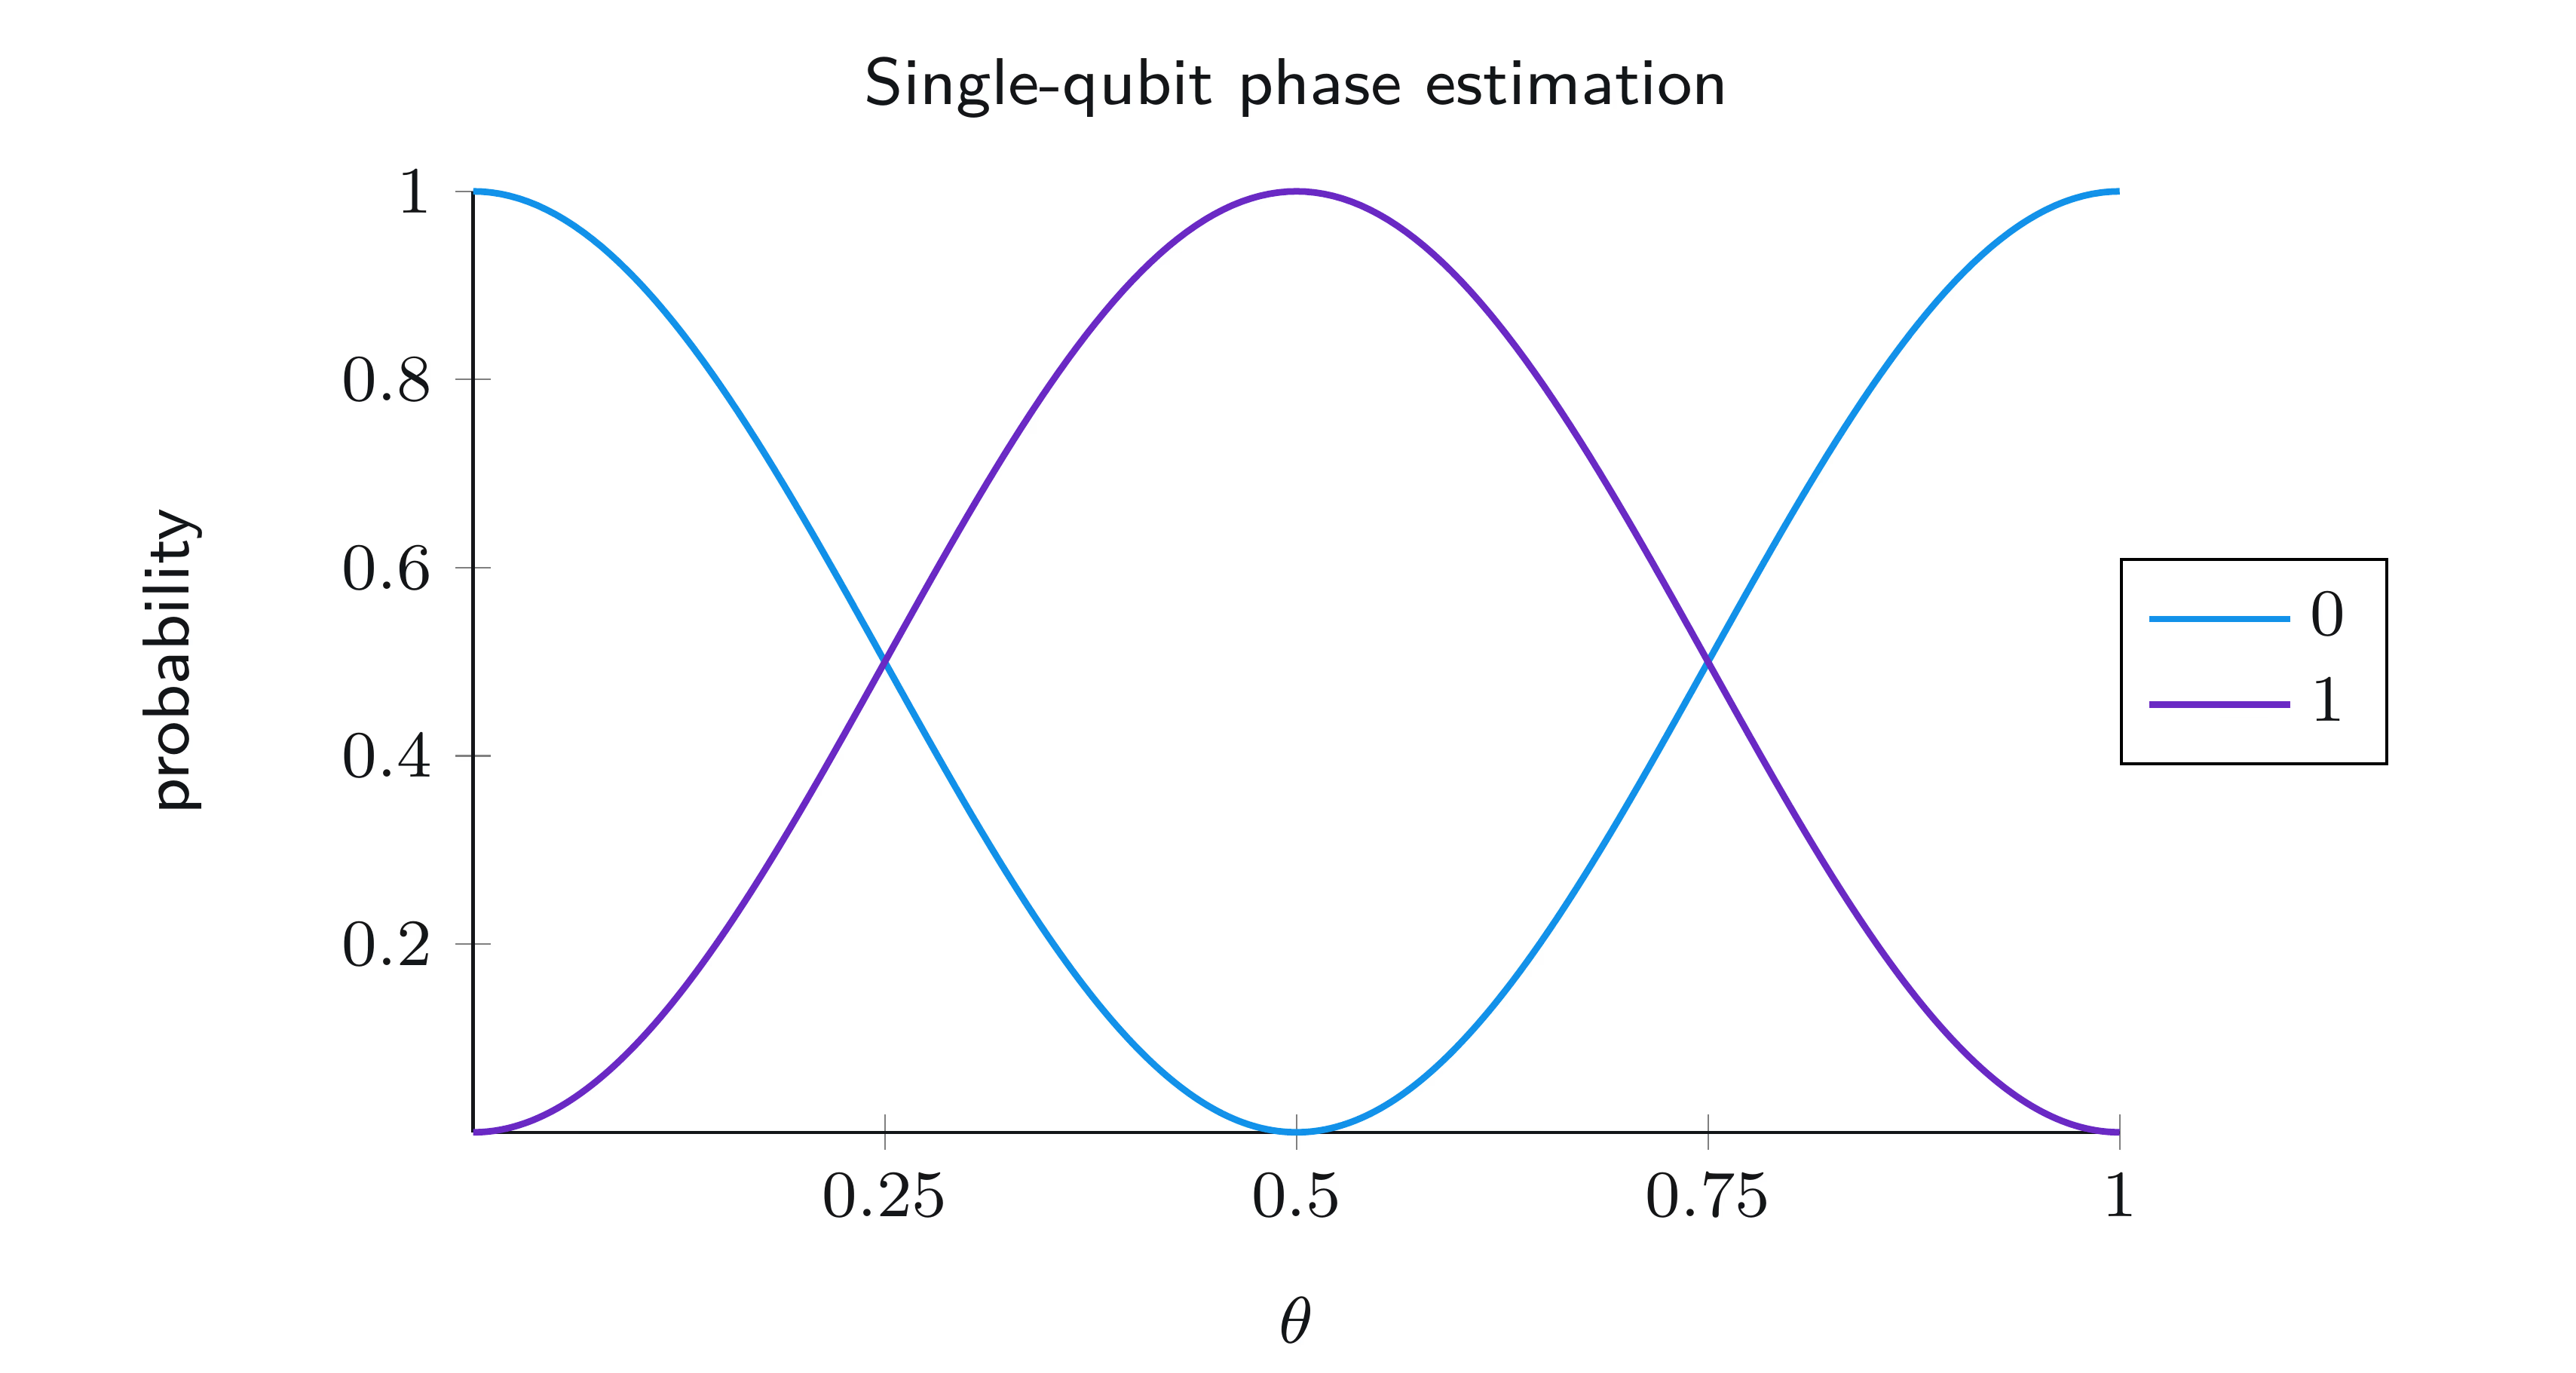

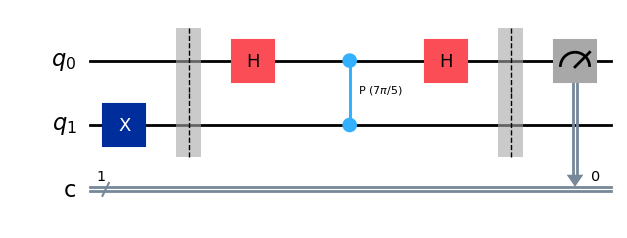

In [34]:
from math import pi, cos, sin
from qiskit import QuantumCircuit

theta = 0.7  # Can be changed to any value between 0 and 1

qc = QuantumCircuit(2, 1)

# Prepare eigenvector, which is the |1> state

qc.x(1)
qc.barrier()

# Implement the estimation procedure
qc.h(0)
qc.cp(2 * pi * theta, 0, 1)
qc.h(0)
qc.barrier()

# Perform the final measurement
qc.measure(0, 0)

# Draw the circuit
display(qc.draw('mpl'))

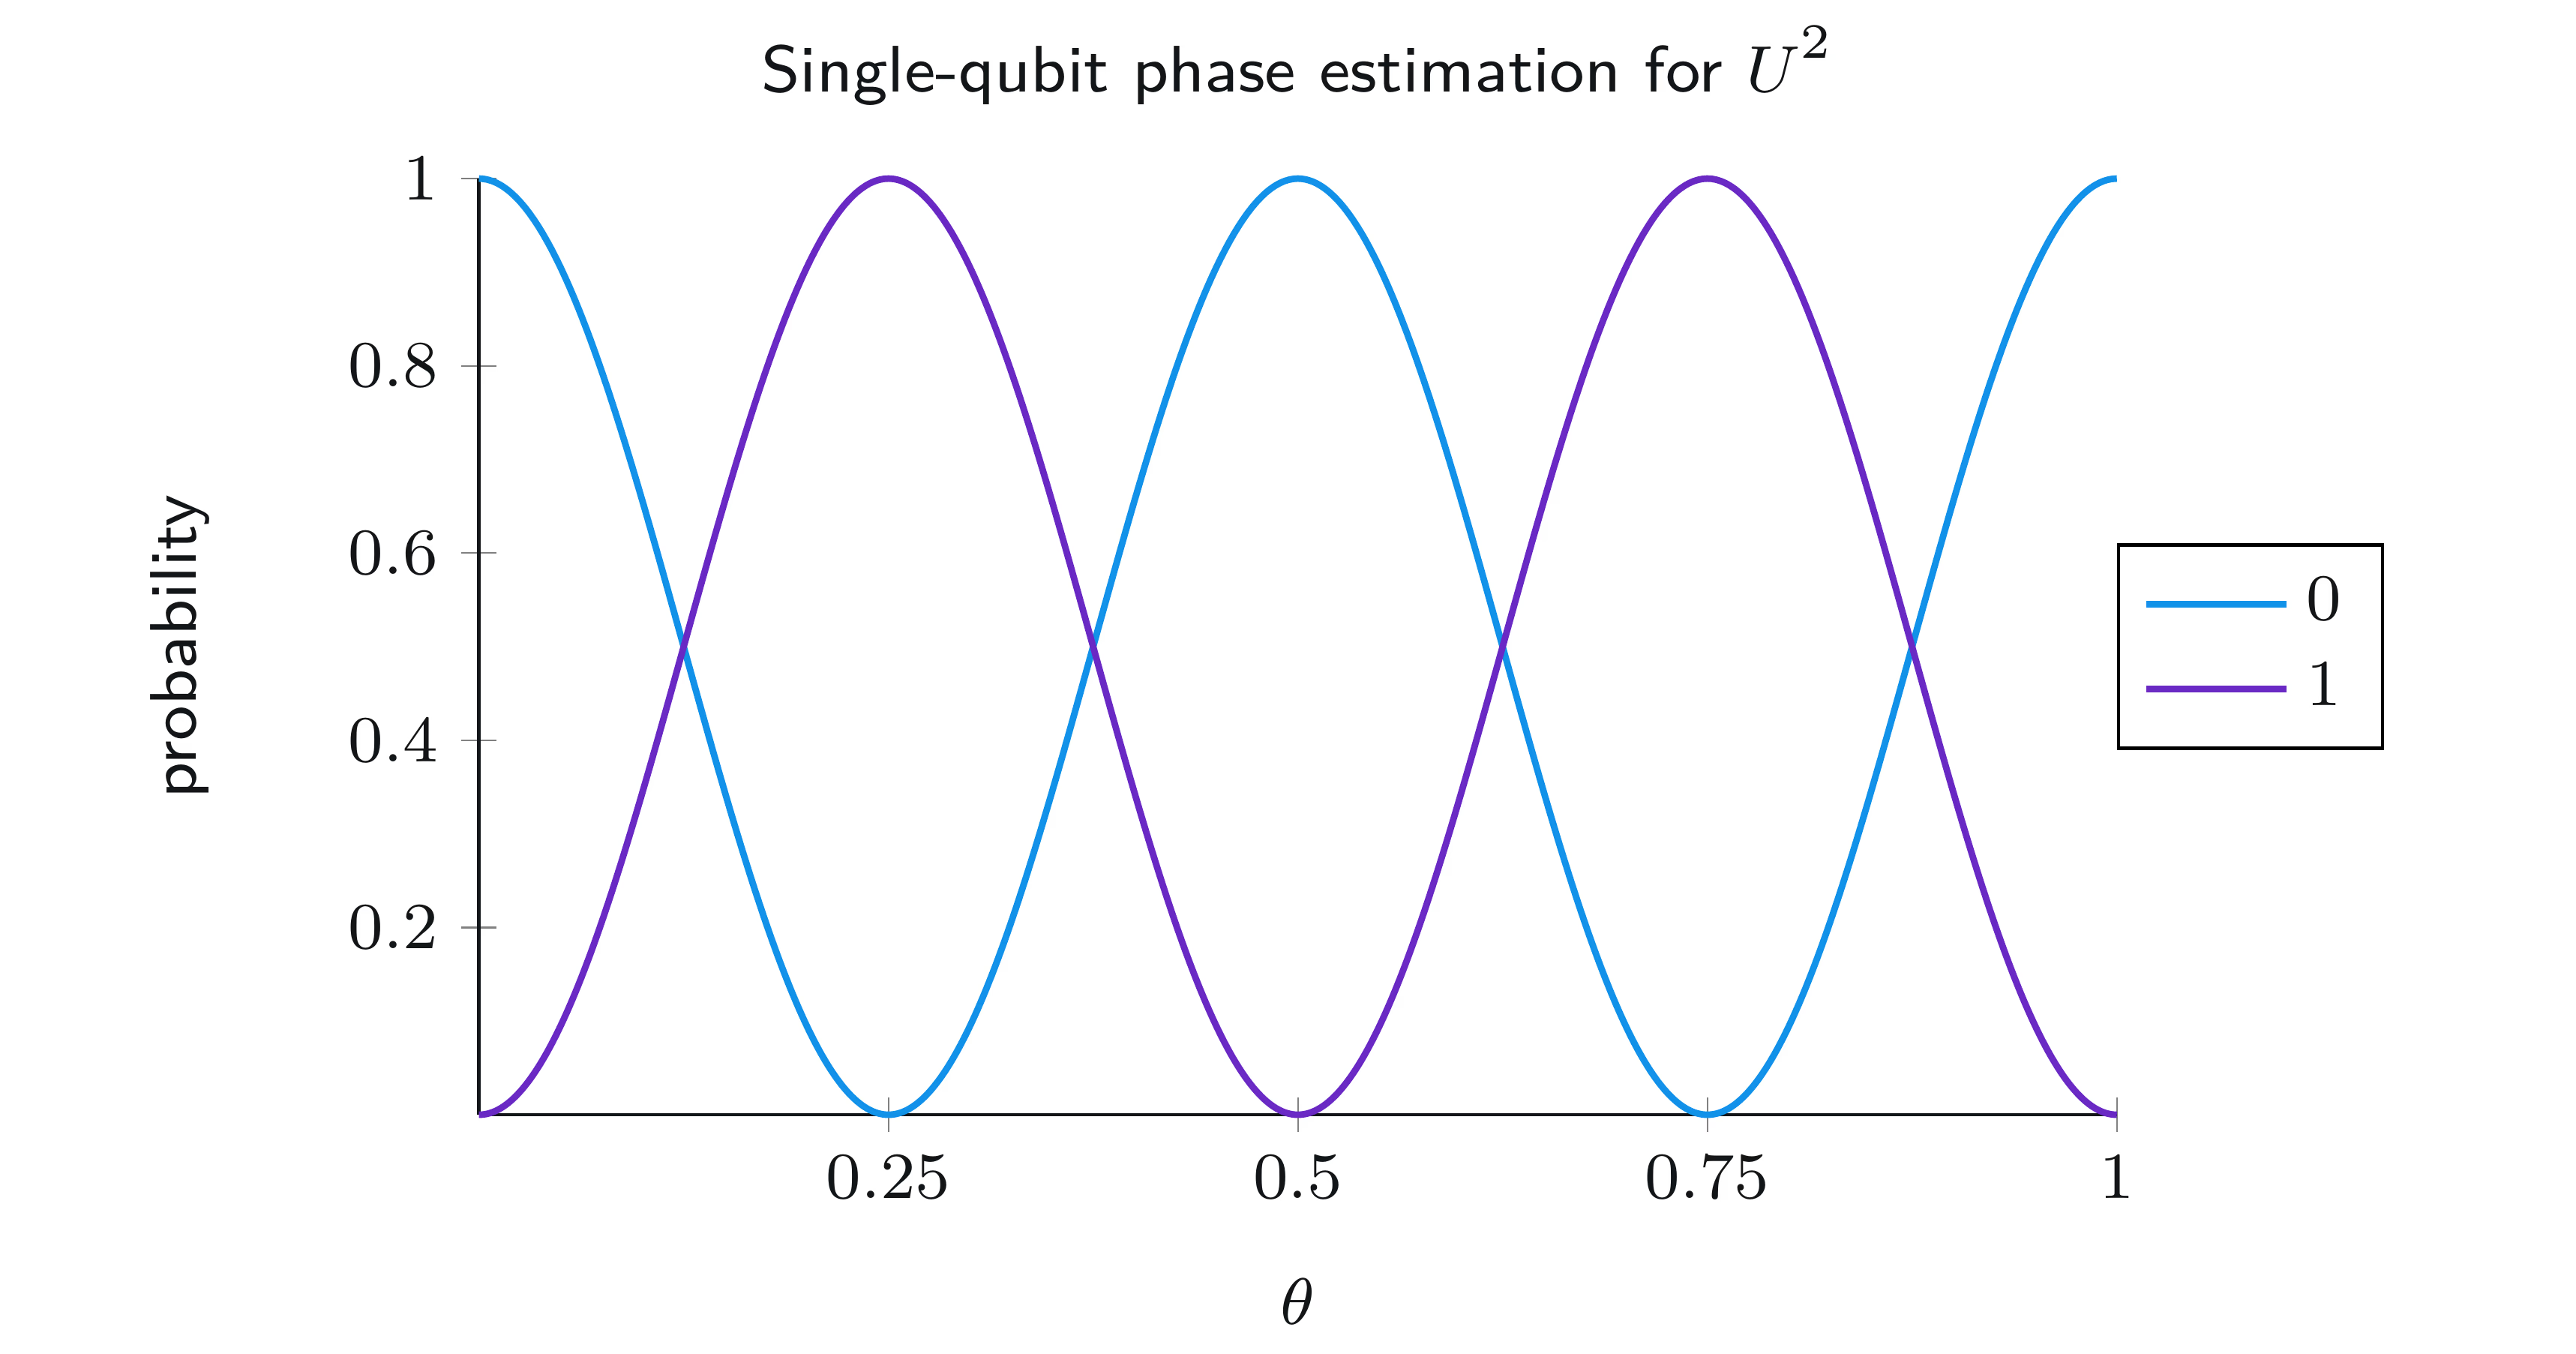

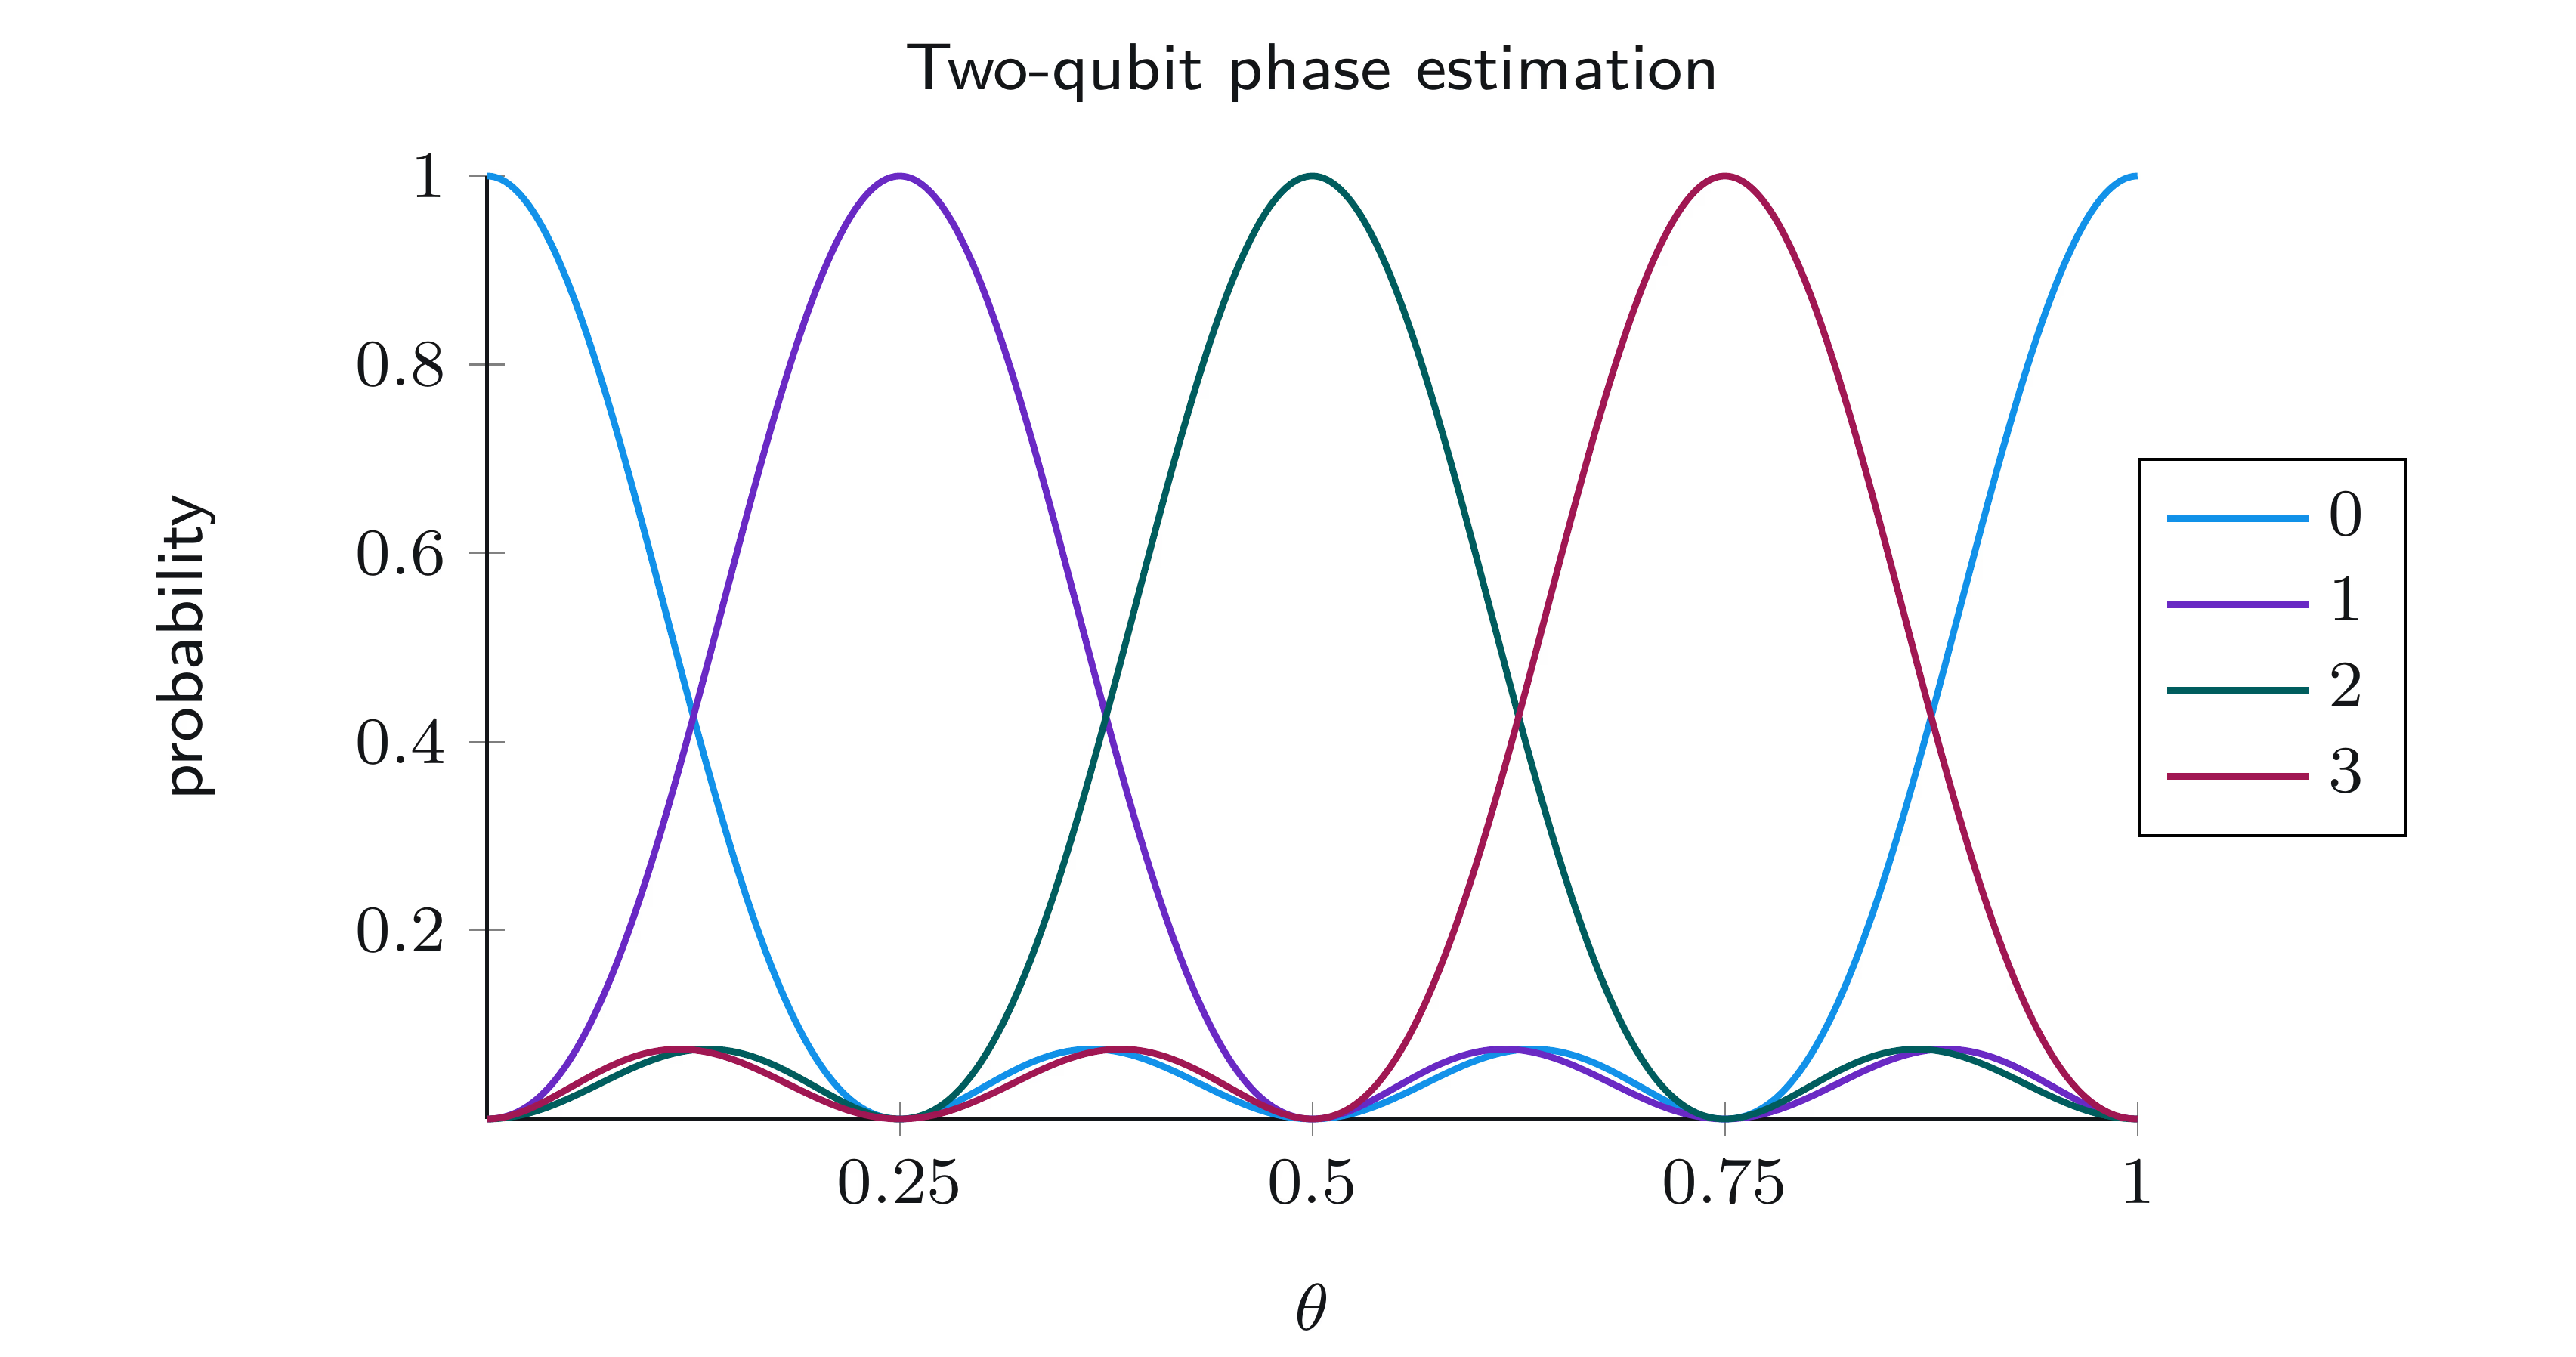

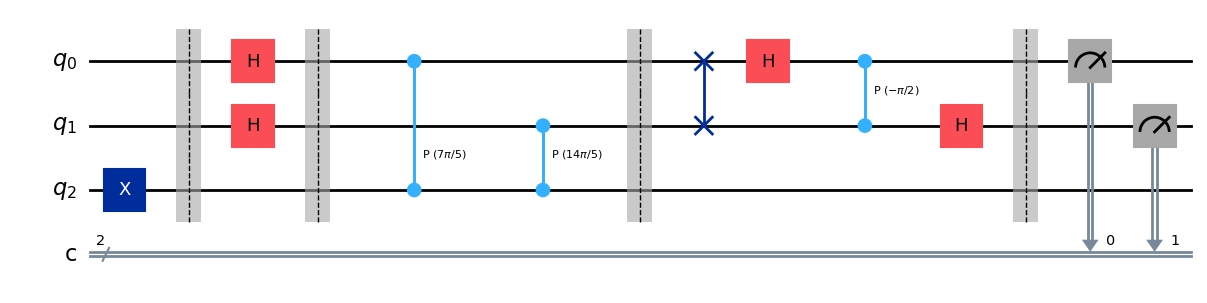

In [36]:
from math import pi
from qiskit import QuantumCircuit

theta = 0.7
qc = QuantumCircuit(3, 2)

# Prepare the eigenvector
qc.x(2)
qc.barrier()

# The initial Hadamard gates
qc.h(0)
qc.h(1)
qc.barrier()

# The controlled unitary gates
qc.cp(2 * pi * theta, 0, 2)
qc.cp(2 * pi * (2 * theta), 1, 2)
qc.barrier()

# An implementation of the inverse of the two-qubit QFT
qc.swap(0, 1)
qc.h(0)
qc.cp(-pi / 2, 0, 1)
qc.h(1)
qc.barrier()

# And finally the measurements
qc.measure([0, 1], [0, 1])
display(qc.draw('mpl'))

In [38]:
from qiskit.primitives import Sampler

display(Sampler().run(qc).result().quasi_dists[0])

/var/folders/kh/9s_l3rg91_951phmfvtb4q6r0000gn/T/ipykernel_10743/1644269935.py:3: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  display(Sampler().run(qc).result().quasi_dists[0])


{0: np.float64(0.032991502812526), 1: np.float64(0.022134898446495), 2: np.float64(0.0625), 3: np.float64(0.882373598740978)}

/var/folders/kh/9s_l3rg91_951phmfvtb4q6r0000gn/T/ipykernel_10743/3145071669.py:3: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  result = Sampler().run(qc).result()


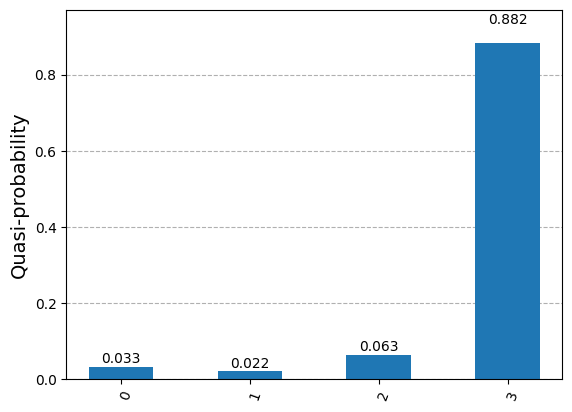

In [39]:
from qiskit.visualization import plot_histogram

result = Sampler().run(qc).result()
display(plot_histogram(result.quasi_dists))

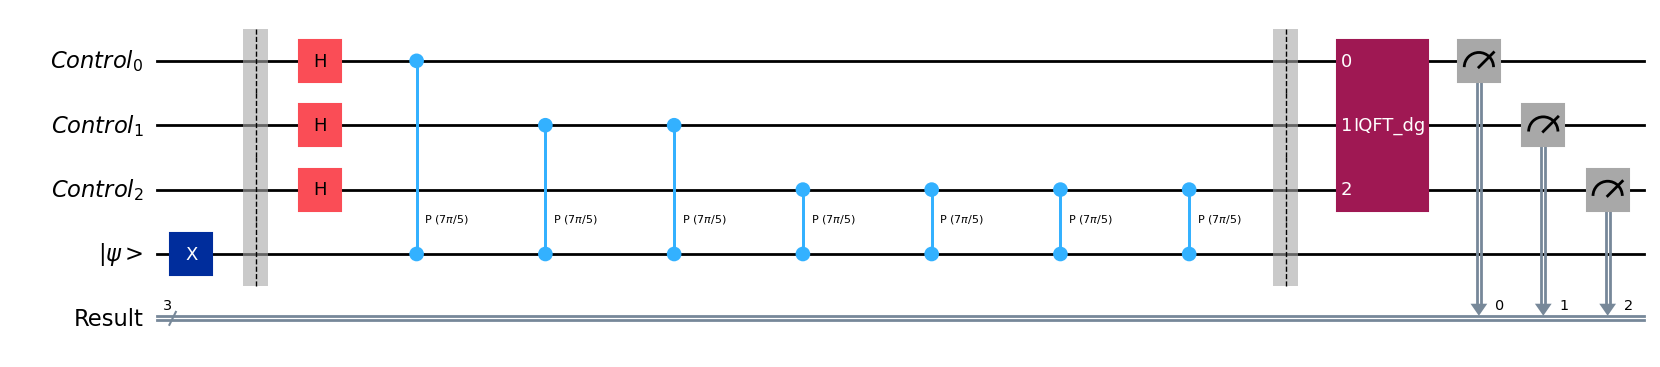

In [41]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT

theta = 0.7
m = 3  # Number of control qubits

control_register = QuantumRegister(m, name="Control")
target_register = QuantumRegister(1, name="|ψ>")
output_register = ClassicalRegister(m, name="Result")
qc = QuantumCircuit(control_register, target_register, output_register)

# Prepare the eigenvector |ψ>
qc.x(target_register)
qc.barrier()

# Perform phase estimation
for index, qubit in enumerate(control_register):
    qc.h(qubit)
    for _ in range(2**index):
        qc.cp(2 * pi * theta, qubit, target_register)
qc.barrier()

# Do inverse quantum Fourier transform
qc.compose(
    QFT(m, inverse=True),
    inplace=True
)

# Measure everything
qc.measure(range(m), range(m))
display(qc.draw('mpl'))

/var/folders/kh/9s_l3rg91_951phmfvtb4q6r0000gn/T/ipykernel_10743/1768351024.py:1: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  result = Sampler().run(qc).result()


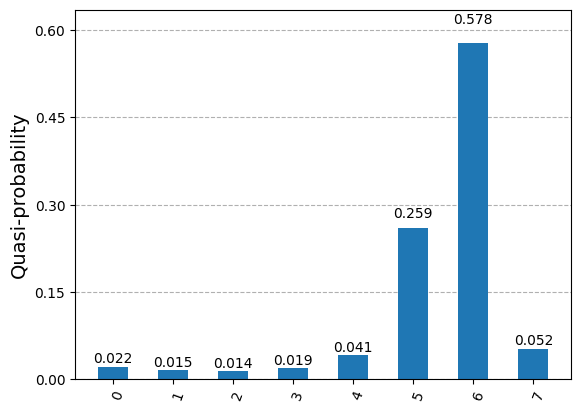

In [42]:
result = Sampler().run(qc).result()
display(plot_histogram(result.quasi_dists))

In [43]:
most_probable = max(result.quasi_dists[0], key=result.quasi_dists[0].get)

print(f"Most probable output: {most_probable}")
print(f"Estimated theta: {most_probable/2**m}")

Most probable output: 6
Estimated theta: 0.75


In [44]:
# shor's algorithm
N = 21
a = 17
max_power = 12

print("k \t a^k \n")
for k in range(1, max_power + 1):
    print(
        "%2d \t %2d" % (k, a**k % N)
    )  # The % operation computes the remainder modulo N

k 	 a^k 

 1 	 17
 2 	 16
 3 	 20
 4 	  4
 5 	  5
 6 	  1
 7 	 17
 8 	 16
 9 	 20
10 	  4
11 	  5
12 	  1


In [45]:
N = 21
a = 18
max_power = 12
print('k \t a^k \n')
for k in range(1, max_power +1):
    print('%2d \t %2d' % (k, a**k % N))

k 	 a^k 

 1 	 18
 2 	  9
 3 	 15
 4 	 18
 5 	  9
 6 	 15
 7 	 18
 8 	  9
 9 	 15
10 	 18
11 	  9
12 	 15


In [46]:
# shor's algorithm  to factor #15
def c_amod15(a):
    '''controlled multiplication by a mod 15, hard-coded for simplicity'''
    if a not in [2,4,7,8,11,13]:
        raise ValueError('a must not have common factors with 15')
    U = QuantumCircuit(4)
    if a in [2, 13]:
        U.swap(2, 3)
        U.swap(1, 2)
        U.swap(0, 1)
    if a in [7, 8]:
        U.swap(0, 1)
        U.swap(1, 2)
        U.swap(2, 3)
    if a in [4, 11]:
        U.swap(1, 3)
        U.swap(0, 2)
    if a in [7, 11, 13]:
        for q in range(4):
            U.x(q)
    U = U.to_gate()
    U.name = f"{a} mod 15"
    c_U = U.control()
    return c_U

In [47]:
def phase_estimation(
        controlled_operation: QuantumCircuit,
        psi_prep: QuantumCircuit,
        precision: int
    ):
    """
    Carry out phase estimation on a simulator.
    Args:
        controlled_operation: The operation to perform phase estimation on,
                              controlled by one qubit.
        psi_prep: Circuit to prepare |ψ>
        precision: Number of counting qubits to use
    Returns:
        float: Best guess for phase of U|ψ>
    """
    control_register = QuantumRegister(precision)
    output_register = ClassicalRegister(precision)

    target_register = QuantumRegister(psi_prep.num_qubits)
    qc = QuantumCircuit(control_register, target_register, output_register)

    # Prepare |ψ>
    qc.compose(psi_prep,
               qubits=target_register,
               inplace=True)

    # Do phase estimation
    for index, qubit in enumerate(control_register):
        qc.h(qubit)
        for _ in range(2**index):
            qc.compose(
                controlled_operation,
                qubits=[qubit] + list(target_register),
                inplace=True,
            )

    qc.compose(
        QFT(precision, inverse=True),
        qubits=control_register,
        inplace=True
    )

    qc.measure(control_register, output_register)

    measurement = Sampler().run(qc, shots=1).result().quasi_dists[0].popitem()[0]
    return measurement / 2**precision

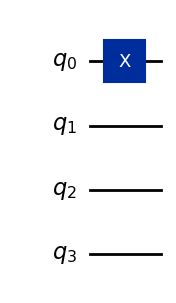

In [49]:
psi_prep = QuantumCircuit(4)
psi_prep.x(0)
display(psi_prep.draw('mpl'))

In [50]:
from fractions import Fraction
from math import gcd

a = 8
N = 15

FACTOR_FOUND = False
ATTEMPT = 0
while not FACTOR_FOUND:
    ATTEMPT += 1
    print(f"\nAttempt {ATTEMPT}")

    phase = phase_estimation(
        c_amod15(a),
        psi_prep,
        precision=8
    )
    frac = Fraction(phase).limit_denominator(N)
    r = frac.denominator
    if phase != 0:
        # Guess for a factor is gcd(x^{r/2} - 1 , 15)
        guess = gcd(a ** (r // 2) - 1, N)
        if guess not in [1, N] and (N % guess) == 0:
            # Guess is a factor!
            print(f"Non-trivial factor found: {guess}")
            FACTOR_FOUND = True


Attempt 1


/var/folders/kh/9s_l3rg91_951phmfvtb4q6r0000gn/T/ipykernel_10743/2139659180.py:45: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  measurement = Sampler().run(qc, shots=1).result().quasi_dists[0].popitem()[0]



Attempt 2

Attempt 3

Attempt 4
Non-trivial factor found: 3


In [51]:
# grover's algorithm
import numpy as np
import math
import matplotlib.pyplot as plt


Scatter plot


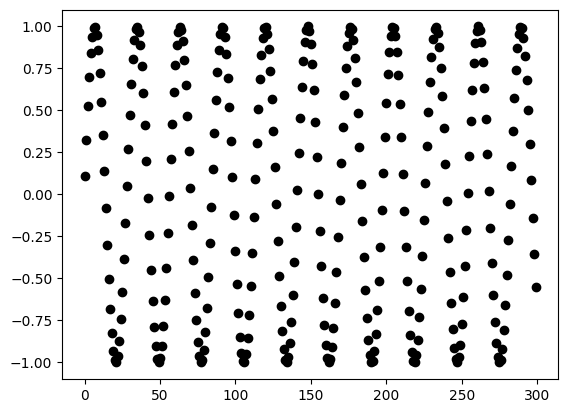

Linear interpolation


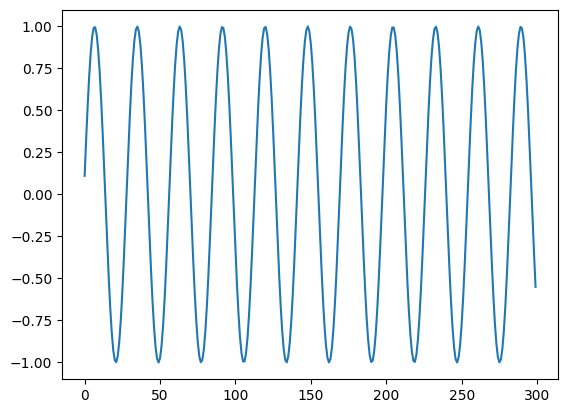

In [52]:
%matplotlib inline

theta = 1 / 9  # angle in radians
t = np.arange(0, 300, 1)  # (start, stop, step)
y = np.sin((2 * t + 1) * theta)

print("Scatter plot")
plt.plot(t, y, "o", color="black")
plt.show()

print("Linear interpolation")
plt.plot(t, y)
plt.show()

In [53]:
for n in range(1, 20):
    N = 2**n
    theta = np.arcsin(np.sqrt(1 / N))
    t = math.floor(np.pi / (4 * theta))
    p = np.sin((2 * t + 1) * theta) ** 2
    print("%d\t %12.10f" % (N, p))

2	 0.5000000000
4	 1.0000000000
8	 0.9453125000
16	 0.9613189697
32	 0.9991823155
64	 0.9965856808
128	 0.9956198657
256	 0.9999470421
512	 0.9994480262
1024	 0.9994612447
2048	 0.9999968478
4096	 0.9999453461
8192	 0.9999157752
16384	 0.9999997811
32768	 0.9999868295
65536	 0.9999882596
131072	 0.9999992587
262144	 0.9999978382
524288	 0.9999997279


In [54]:
# We'll start the loop with n=2 to stay within the domain of arcsin.
# (Note that we can't have 4 solutions when n=1.)

for n in range(2, 20):
    N = 2**n
    old_theta = np.arcsin(np.sqrt(1 / N))
    new_theta = np.arcsin(np.sqrt(4 / N))
    t = math.floor(np.pi / (4 * old_theta))
    p = np.sin((2 * t + 1) * new_theta) ** 2
    print("%d\t %12.10f" % (N, p))

4	 1.0000000000
8	 0.5000000000
16	 0.2500000000
32	 0.0122070313
64	 0.0203807689
128	 0.0144530758
256	 0.0000705058
512	 0.0019310741
1024	 0.0023009083
2048	 0.0000077506
4096	 0.0002301502
8192	 0.0003439882
16384	 0.0000007053
32768	 0.0000533810
65536	 0.0000472907
131072	 0.0000030066
262144	 0.0000086824
524288	 0.0000010820
